In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# from kmodes.kprototypes import KPrototypes

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator

from sklearn.decomposition import PCA


from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")

In [10]:
df_raw = pd.read_csv('../country_data_clustering/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = df_raw.copy()

In [11]:
#check for missing value
df.isnull().values.any()

False

In [12]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [24]:
# def get_zeroes(x:str)->str:
#     """_summary_

#     Args:
#         x (str): _description_

#     Returns:
#         str: _description_
#     """
#     if x == ' ':
#         return '0'
#     return x

In [26]:
#deal with the empty total charges
df = df[df['TotalCharges'] != ' ']

In [27]:
# The k-Means and Mean Shift algorithms can only process numerical data. Therefore, we will transform source data that are not float values to integers to make them mathematically digestible.

#type conversions

df['tenure'] = df['tenure'].astype(np.float64) # -> Columns to which we want to apply aggregation functions such as sum or mean
df['TotalCharges'] = df['TotalCharges'].astype(np.float64)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object) # ->Columns that will not be subject to computations, apart from counting their elements, in preparation for the upcoming conversion steps.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   float64
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [29]:
# visualize the unique categorical element per column
print(df.select_dtypes('object').nunique())

# stats on the numerical variables
df.select_dtypes(exclude='object').describe()

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
Churn                  2
dtype: int64


,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [31]:
df1 = df.drop(['customerID'],axis=1).copy()

In [32]:
#scale the numerical values -> so the model doesn't get trapped by large differences between the column value
numcols = list(df1.dtypes[df1.dtypes=='float64'].index)
print(numcols)
scaler = StandardScaler()
df1[numcols] = scaler.fit_transform(df1[numcols])
df1.describe()

['tenure', 'MonthlyCharges', 'TotalCharges']


,tenure,MonthlyCharges,TotalCharges
count,7.032000e+03,7.032000e+03,7.032000e+03
mean,-1.214741e-16,9.652878e-17,-1.172113e-16
std,1.000071e+00,1.000071e+00,1.000071e+00
min,-1.280248e+00,-1.547283e+00,-9.990692e-01
25%,-9.542963e-01,-9.709769e-01,-8.302488e-01
50%,-1.394171e-01,1.845440e-01,-3.908151e-01
75%,9.199259e-01,8.331482e-01,6.668271e-01
max,1.612573e+00,1.793381e+00,2.824261e+00


In [33]:
# helper function: translate category column to numerical column
def catcode(df, col): 
    df[col + "_n"] = df[col].astype("category").cat.codes
    df = df.drop(col, axis=1, inplace=True)

# create numerical columns from categories
_ = [catcode(df1, col) for col in list(df1.dtypes[df1.dtypes == np.object].index)]
print(df1.select_dtypes(exclude="object").nunique())
df1.describe()

tenure                  72
MonthlyCharges        1584
TotalCharges          6530
gender_n                 2
SeniorCitizen_n          2
Partner_n                2
Dependents_n             2
PhoneService_n           2
MultipleLines_n          3
InternetService_n        3
OnlineSecurity_n         3
OnlineBackup_n           3
DeviceProtection_n       3
TechSupport_n            3
StreamingTV_n            3
StreamingMovies_n        3
Contract_n               3
PaperlessBilling_n       2
PaymentMethod_n          4
Churn_n                  2
dtype: int64


,tenure,MonthlyCharges,TotalCharges,gender_n,SeniorCitizen_n,Partner_n,Dependents_n,PhoneService_n,MultipleLines_n,InternetService_n,OnlineSecurity_n,OnlineBackup_n,DeviceProtection_n,TechSupport_n,StreamingTV_n,StreamingMovies_n,Contract_n,PaperlessBilling_n,PaymentMethod_n,Churn_n
count,7.032000e+03,7.032000e+03,7.032000e+03,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,-1.214741e-16,9.652878e-17,-1.172113e-16,0.504693,0.162400,0.482509,0.298493,0.903299,0.940557,0.872582,0.789249,0.905859,0.903868,0.796359,0.984926,0.992890,0.688567,0.592719,1.573237,0.265785
std,1.000071e+00,1.000071e+00,1.000071e+00,0.500014,0.368844,0.499729,0.457629,0.295571,0.948627,0.737271,0.859962,0.880394,0.880178,0.861674,0.885285,0.885385,0.832934,0.491363,1.067504,0.441782
min,-1.280248e+00,-1.547283e+00,-9.990692e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-9.542963e-01,-9.709769e-01,-8.302488e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-1.394171e-01,1.845440e-01,-3.908151e-01,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000
75%,9.199259e-01,8.331482e-01,6.668271e-01,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000
max,1.612573e+00,1.793381e+00,2.824261e+00,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000


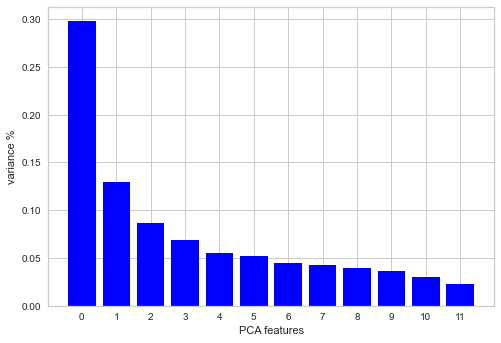

In [34]:
# principal components
pca = PCA(n_components=12)
res_pca = pca.fit_transform(df1)

# scree plot
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color="blue")
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

df1_pca = pd.DataFrame(res_pca)

In [35]:
frTRAIN = 0.8               # % size of training dataset
RNDN = 42                   # random state
nK = 12                     # initial guess: clusters

  0%|          | 0/3 [00:00<?, ?it/s]

Elbow Score Plot (distortion metric):
elbow value = optimal k: 5  | elbow score: 52,765.616


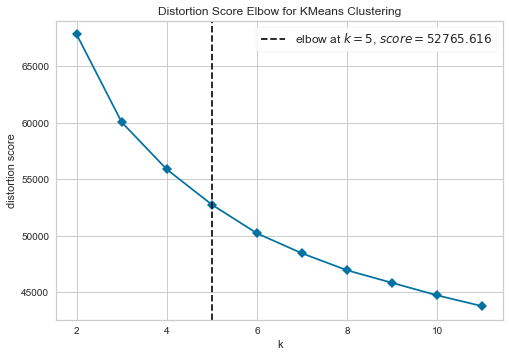

 33%|███▎      | 1/3 [00:03<00:06,  3.32s/it]

Elbow Score Plot (silhouette metric):
elbow value = optimal k: 2  | elbow score: 0.205


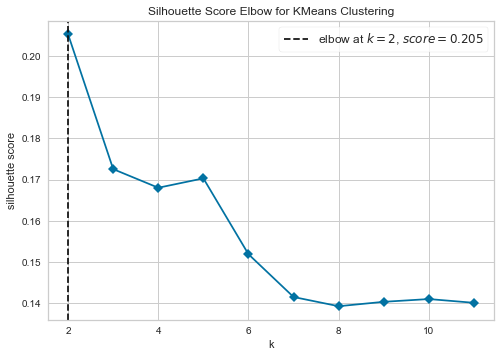

 67%|██████▋   | 2/3 [00:10<00:04,  4.46s/it]

Elbow Score Plot (calinski_harabasz metric):
elbow value = optimal k: 2  | elbow score: 1,895.329


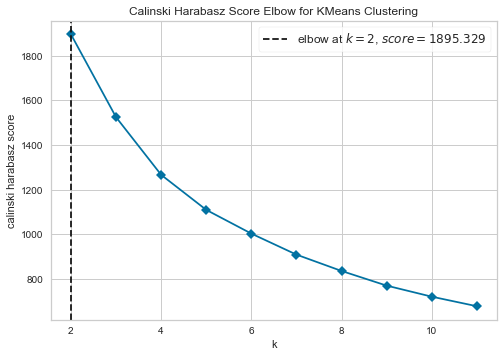

100%|██████████| 3/3 [00:12<00:00,  4.18s/it]


In [36]:
# elbow score plot with Yellowbrick
def elbowplot(df, elbowmetric, model):
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    vis = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  
    
    
    
# call elbow plot for each of 3 alternative metrics
    # distortion = mean sum of squared distances to center
    # silhouette = mean ratio of intra-cluster and nearest-cluster distance
    # calinski = ratio of within to between cluster dispersion

model = KMeans(random_state=RNDN)
_ = [elbowplot(df1, m, model) for m in tqdm(["distortion", "silhouette", "calinski_harabasz"])]    


inertia scores (sum of squared errors) by number of clusters:
2 : 67,817
3 : 60,052
4 : 55,884
5 : 52,766
6 : 50,228
7 : 48,457
8 : 46,959
9 : 45,847
10 : 44,740
11 : 43,784


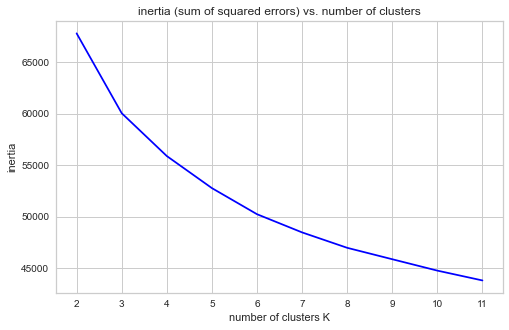

In [37]:
# kmeans: looking for the elbow - compare number of clusters by their inertia scores

# run kMeans for alternative number of clusters k
inertia_scores = [KMeans(
                    n_clusters=k, 
                    init='k-means++', 
                    n_init=10, max_iter=100, random_state=RNDN). \
                    fit(df1).inertia_ \
                    for k in range(2,nK)]


dict_inertia = dict(zip(range(2,nK), inertia_scores))
print("inertia scores (sum of squared errors) by number of clusters:")
_ = [print(k, ":", f'{v:,.0f}') for k,v in dict_inertia.items()]

# scree plot: look for elbow
plt.figure(figsize=[8,5])
plt.plot(range(2,nK), inertia_scores, color="blue")
plt.title("inertia (sum of squared errors) vs. number of clusters")
plt.xticks(np.arange(2,nK,1.0))
plt.xlabel("number of clusters K")
plt.ylabel("inertia");

In [39]:
# inertia scores: confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concavem will detect knees
inertia_knee_a3 = KneeLocator(
        range(2,nK), 
        inertia_scores, 
        S=0.1, curve="convex", direction="decreasing")

K_inertia_a3 = inertia_knee_a3.elbow   
print("elbow at k =", f'{K_inertia_a3:.0f} clusters')

elbow at k = 5 clusters


In [40]:
# kMeans: silhouette score
# initial example: silhouette score for 4 clusters
k = 4
model = KMeans(n_clusters=k, random_state=RNDN, verbose=0)
clusters_assigned = model.fit_predict(df1)
K_sil_a3 = silhouette_score(df1, clusters_assigned)
print("silhouette score for", k, "clusters: " f'{K_sil_a3:.3f}')

silhouette score for 4 clusters: 0.168


100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

silhouette scores:
2 : 0.205
3 : 0.173
4 : 0.168
5 : 0.170
6 : 0.152
7 : 0.142
8 : 0.139
9 : 0.140
10 : 0.141
11 : 0.140
maximum silhouette score for 2 clusters:  0.205


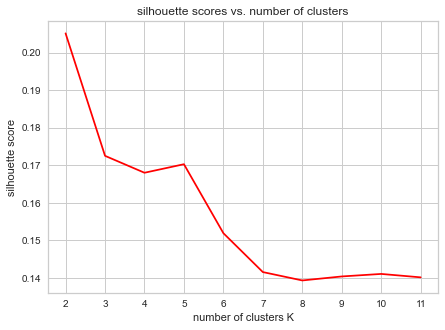

In [41]:
# find maximum silhouette score for up to kN clusters
sil_scores = [silhouette_score(
                                df1, 
                                KMeans(n_clusters=k, random_state=RNDN). \
                                fit_predict(df1)) \
                                for k in tqdm(range(2,nK))]

dict_sil = dict(zip(range(2,nK), sil_scores))
print("silhouette scores:")
_ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
K_sil_a3 = max(dict_sil, key=dict_sil.get)            # optimal clusters
sil_opt_a3 = dict_sil[K_sil_a3]                       # optimal silhouette score
print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

plt.figure(figsize=[7,5])
plt.plot(range(2,nK), sil_scores, color="red")
plt.title("silhouette scores vs. number of clusters")
plt.xticks(np.arange(2,nK,1))
plt.xlabel("number of clusters K")
plt.ylabel("silhouette score")
plt.show()

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


silhouette scores for k clusters:
2 : 0.205
3 : 0.173
4 : 0.168
5 : 0.170
6 : 0.152
7 : 0.142
8 : 0.139
9 : 0.140
10 : 0.141
11 : 0.140
maximum silhouette score for 2 clusters:  0.205


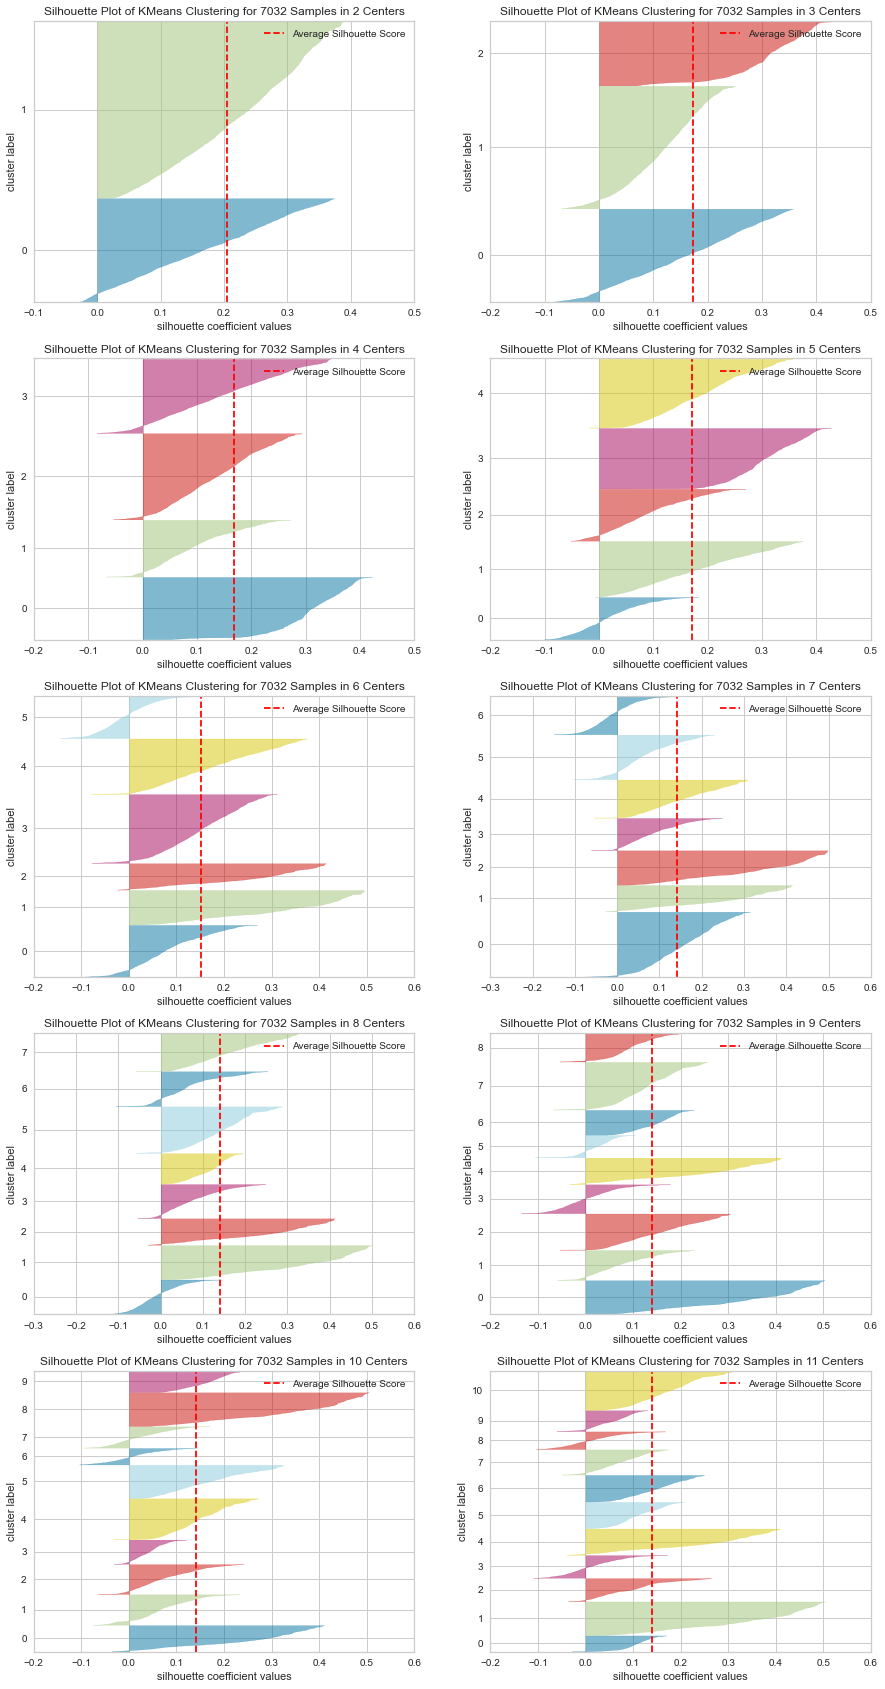

In [42]:
# silhouette score plots with Yellowbrick
dict_score = dict()
fig, ax = plt.subplots(int(np.ceil(nK/2)-1), 2, figsize=(15,30))

for i in tqdm(range(2,nK)):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=RNDN)
    
    q, mod = divmod(i, 2)
    vis = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod], is_fitted=False)
    vis.fit(df1)
    vis.finalize()
    dict_score[i] = vis.silhouette_score_


print("silhouette scores for k clusters:")
_ = [print(k,":",f'{v:.3f}') for k,v in dict_score.items()]

K_sil_a3 = max(dict_score, key=dict_score.get)          # optimal clusters
sil_opt_a3 = dict_score[K_sil_a3]                       # optimal (maximal) silhouette score
print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')


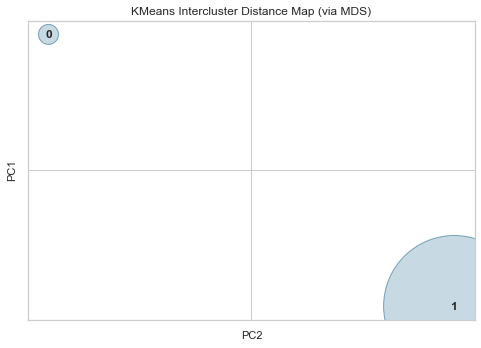

In [43]:

# optimal number of clusters: intercluster distances
model = KMeans(
    n_clusters=K_sil_a3, init='k-means++', n_init=10, max_iter=100, random_state=RNDN)
visD = InterclusterDistance(
    model, max_size=20000, legend=False, random_state=RNDN)
visD.fit(df1)
visD.finalize()

100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


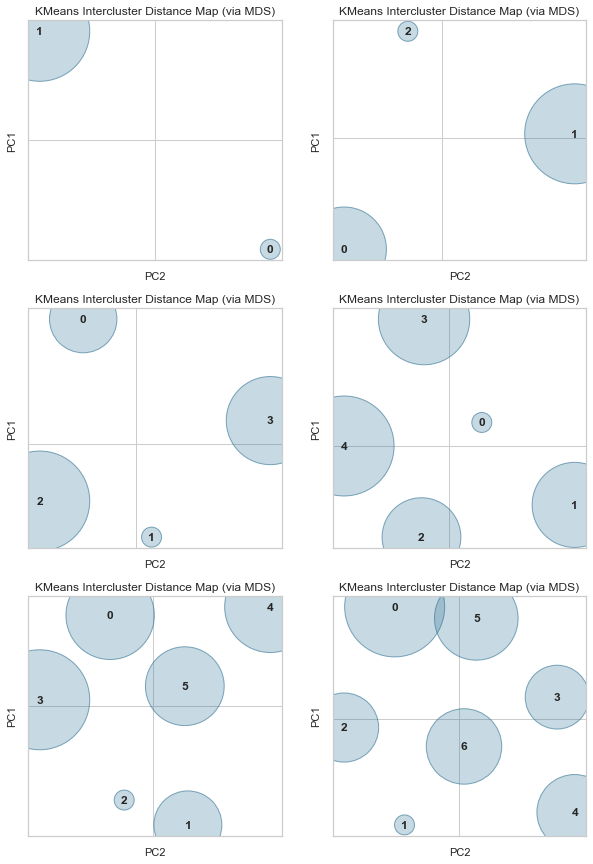

In [44]:
# intercluster distance maps: alternative numbers of clusters
dict_score = dict()
nK = 8
fig, ax = plt.subplots(int(np.ceil(nK/2))-1, 2, figsize=(10,15))

for i in tqdm(range(2,nK)):
    km = KMeans(
                n_clusters=i, 
                init='k-means++', n_init=10, max_iter=100, random_state=RNDN)
    
    q, mod = divmod(i, 2)
    vis = InterclusterDistance(
        km, ax=ax[q-1][mod], max_size=10000, legend=False, random_state=RNDN)
    vis.fit(df1)
    vis.finalize()
    dict_score[i] = vis.scores_

In [49]:
# %split training vs test dataset
df_train, df_test = train_test_split(df1, train_size=frTRAIN, random_state=RNDN)


# training: generate "Cluster" column based on optimal number of clusters
model = KMeans(n_clusters=5, random_state=RNDN)
res = model.fit_predict(df_train)
df_train.insert(0, "Cluster", res)     # insert cluster labels as new column
df_train.tail()


# training: get silhouette score
sil_train = silhouette_score(df_train, res)
# print("training: silhouette score for", f'{K_sil_a3:.0f} clusters: {sil_train:.3f}')

In [50]:
df_train

,Cluster,tenure,MonthlyCharges,TotalCharges,gender_n,SeniorCitizen_n,Partner_n,Dependents_n,PhoneService_n,MultipleLines_n,...,OnlineSecurity_n,OnlineBackup_n,DeviceProtection_n,TechSupport_n,StreamingTV_n,StreamingMovies_n,Contract_n,PaperlessBilling_n,PaymentMethod_n,Churn_n
6030,3,0.430998,-0.523477,-0.091370,0,0,0,0,0,1,...,0,0,2,0,2,2,0,1,0,1
3410,1,-1.198760,-0.378881,-0.924111,1,0,0,0,1,0,...,0,0,0,0,2,0,0,0,1,1
5483,3,0.919926,0.430523,0.959516,0,0,1,0,1,2,...,0,0,2,0,0,0,0,1,2,1
5524,2,0.512486,-0.337331,0.119297,1,0,1,1,1,0,...,2,0,0,2,0,0,2,0,0,0
6337,4,0.919926,1.200040,1.396490,0,0,1,1,1,2,...,2,0,0,0,2,2,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3778,1,-1.198760,-0.478603,-0.946811,1,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
5199,4,0.756950,1.552388,1.508839,0,0,0,0,1,2,...,0,2,2,2,2,2,1,1,2,0
5235,1,-0.954296,0.543541,-0.661274,1,0,0,0,1,2,...,2,0,0,0,0,0,0,1,2,0
5399,0,0.716206,-1.497422,-0.571007,0,0,0,0,1,0,...,1,1,1,1,1,1,1,0,0,0


In [ ]:
####################################  Interpretation: Cluster Profiling and Dashboard #############################################

In [51]:
df1['Clusters'] = model.fit_predict(df1)

In [53]:
#size of clusters -> to check that there are no obvious outliers or exotic tiny clusters, nor a dominant cluster that dwarfs the others.
df_grp = df1.groupby('Clusters').count()
df_grp

,tenure,MonthlyCharges,TotalCharges,gender_n,SeniorCitizen_n,Partner_n,Dependents_n,PhoneService_n,MultipleLines_n,InternetService_n,OnlineSecurity_n,OnlineBackup_n,DeviceProtection_n,TechSupport_n,StreamingTV_n,StreamingMovies_n,Contract_n,PaperlessBilling_n,PaymentMethod_n,Churn_n
Clusters,,,,,,,,,,,,,,,,,,,,
0,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062
1,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404,1404
2,1308,1308,1308,1308,1308,1308,1308,1308,1308,1308,1308,1308,1308,1308,1308,1308,1308,1308,1308,1308
3,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523
4,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735,1735


In [56]:
df['Clusters'] = df1['Clusters']

In [57]:
pd.crosstab(df['Clusters'],
            df['Churn'],
            values=df['MonthlyCharges'],
            aggfunc='mean',
            normalize=False)

Churn,No,Yes
Clusters,,
0,65.129369,71.139474
1,94.665826,101.409714
2,85.138605,90.476923
3,21.200106,20.368142
4,57.455263,63.594289


In [59]:
pd.crosstab(df['Clusters'],
            df['StreamingTV'],
            values=df['StreamingTV'],
            aggfunc='count',
            normalize=False)

StreamingTV,No,No internet service,Yes
Clusters,,,
0,844.0,NaN,218.0
1,171.0,NaN,1233.0
2,255.0,NaN,1053.0
3,2.0,1520.0,1.0
4,1537.0,NaN,198.0


In [61]:
#most frequent column values for each cluster
df.groupby(['Clusters']).agg(lambda x: x.value_counts().index[0])

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
Clusters,,,,,,,,,,,,,,,,,,,,,
0,2325-ZUSFD,Male,0,Yes,No,72.0,Yes,No,DSL,Yes,...,No,Yes,No,No,One year,Yes,Bank transfer (automatic),84.80,1782.00,No
1,4355-HBJHH,Female,0,Yes,No,72.0,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),99.00,4976.15,No
2,5349-IECLD,Male,0,No,No,1.0,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.40,2317.10,Yes
3,7696-CFTAT,Male,0,No,No,1.0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.05,20.20,No
4,6917-IAYHD,Male,0,No,No,1.0,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.40,45.30,No


In [67]:
# helper function: pie charts for categorical variables
def cluster_pies(df):
    
    # number of categorical variables
    c = len(df.select_dtypes("object").nunique())
    
    # number of clusters
    K = df["Clusters"].nunique()

    for k in tqdm(range(K)):
        dfc = df[df["Clusters"]==k]
        chrg = dfc["MonthlyCharges"].median()
        ten = dfc["tenure"].median()
        cases = dfc.shape[0]

        fig = plt.figure(figsize=(50, 12))
        fig.suptitle("Clusters " + str(k) + ": " + \
            f'{cases:,.0f}' + " cases | " + \
            "median charge " + f'{chrg:.2f}' + \
            " | median tenure " + f'{ten:.0f}')


        ax1 = plt.subplot2grid((2,c),(0,0))
        plt.pie(dfc["Contract"].value_counts(), labels=dfc["Contract"].unique())
        plt.title("Contract");

        ax1 = plt.subplot2grid((2,c),(0,1))
        plt.pie(dfc["gender"].value_counts(), labels=dfc["gender"].unique())
        plt.title("gender");

        ax1 = plt.subplot2grid((2,c),(0,2))
        plt.pie(dfc["SeniorCitizen"].value_counts(), labels=dfc["SeniorCitizen"].unique())
        plt.title("SeniorCitizen");

        ax1 = plt.subplot2grid((2,c),(0,3))
        plt.pie(dfc["Partner"].value_counts(), labels=dfc["Partner"].unique())
        plt.title("Partner");

        ax1 = plt.subplot2grid((2,c),(0,4))
        plt.pie(dfc["PhoneService"].value_counts(), labels=dfc["PhoneService"].unique())
        plt.title("PhoneService");

        ax1 = plt.subplot2grid((2,c),(0,5))
        plt.pie(dfc["InternetService"].value_counts(), labels=dfc["InternetService"].unique())
        plt.title("InternetService");

        ax1 = plt.subplot2grid((2,c),(0,6))
        plt.pie(dfc["StreamingTV"].value_counts(), labels=dfc["StreamingTV"].unique())
        plt.title("StreamingTV");

In [65]:
def cluster_profile(df):
    dfc = df.groupby("Clusters").agg({ 
        "MonthlyCharges": "median",
        "Contract": lambda x: x.value_counts().index[0],
        "tenure": "median",
        "gender": lambda x: x.value_counts().index[0],
        "SeniorCitizen": lambda x: x.value_counts().index[0],
        "Partner": lambda x: x.value_counts().index[0],
        "Dependents": lambda x: x.value_counts().index[0],
        "PhoneService": lambda x: x.value_counts().index[0],
        "InternetService": lambda x: x.value_counts().index[0],
        "StreamingTV": lambda x: x.value_counts().index[0],
        "PaperlessBilling": lambda x: x.value_counts().index[0],
        "PaymentMethod": lambda x: x.value_counts().index[0],
        "Churn": lambda x: x.value_counts().index[0]
                                    })    #.sort_values(by=["MonthlyCharges"], ascending=False)

    cluster_pies(df)
    return dfc

100%|██████████| 5/5 [00:00<00:00,  6.26it/s]


Clusters,0,1,2,3,4
MonthlyCharges,65.275,99.45,90.65,20.15,62.8
Contract,One year,Two year,Month-to-month,Two year,Month-to-month
tenure,46,65,22,25,6
gender,Male,Female,Male,Male,Male
SeniorCitizen,0,0,0,0,0
Partner,Yes,Yes,No,No,No
Dependents,No,No,No,No,No
PhoneService,Yes,Yes,Yes,Yes,Yes
InternetService,DSL,Fiber optic,Fiber optic,No,DSL
StreamingTV,No,Yes,Yes,No internet service,No


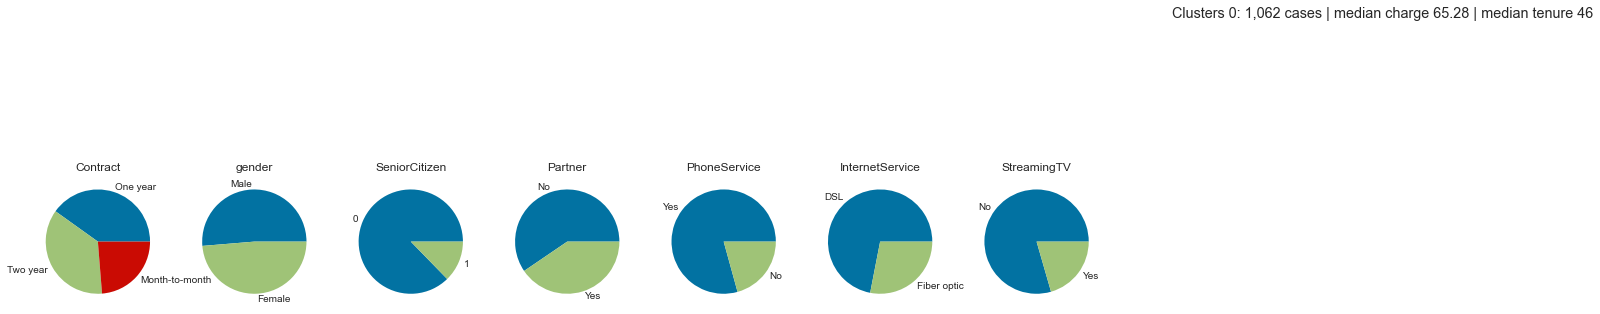

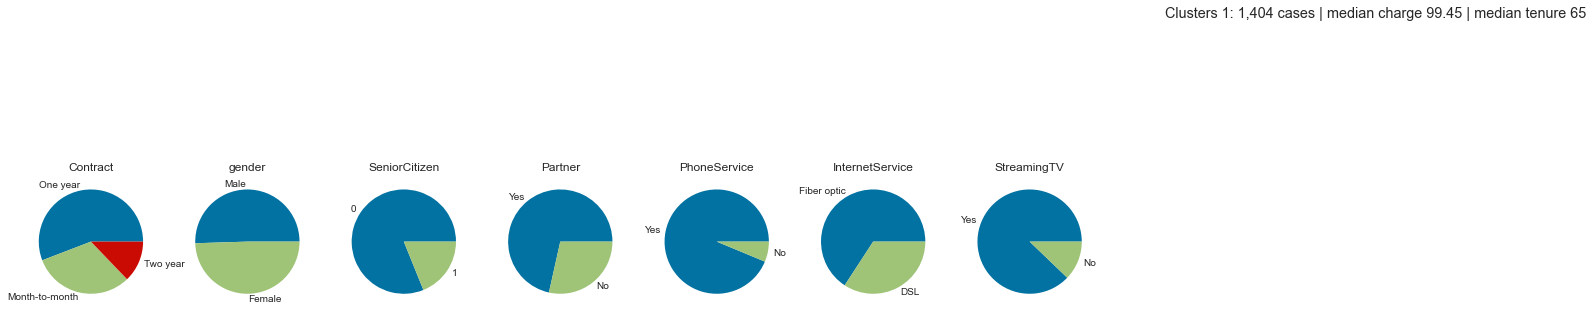

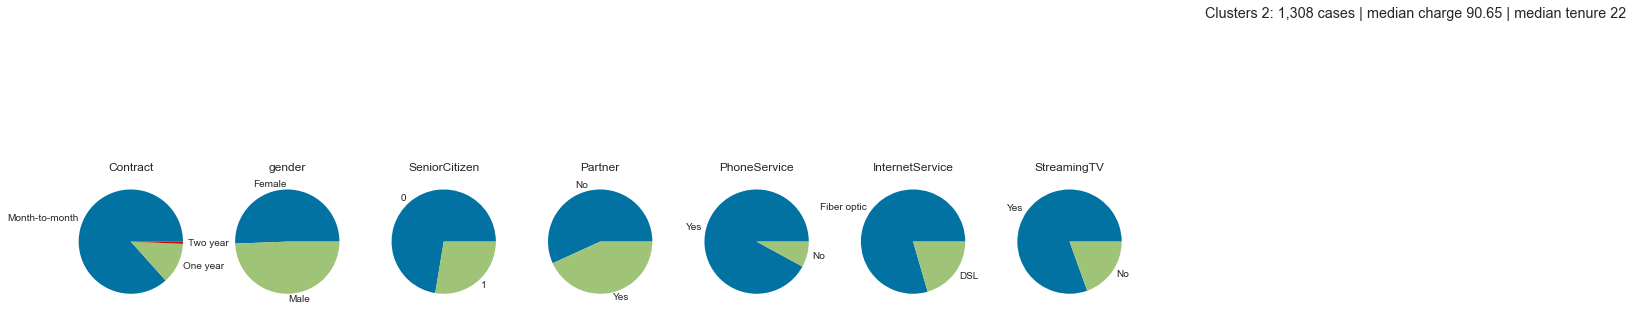

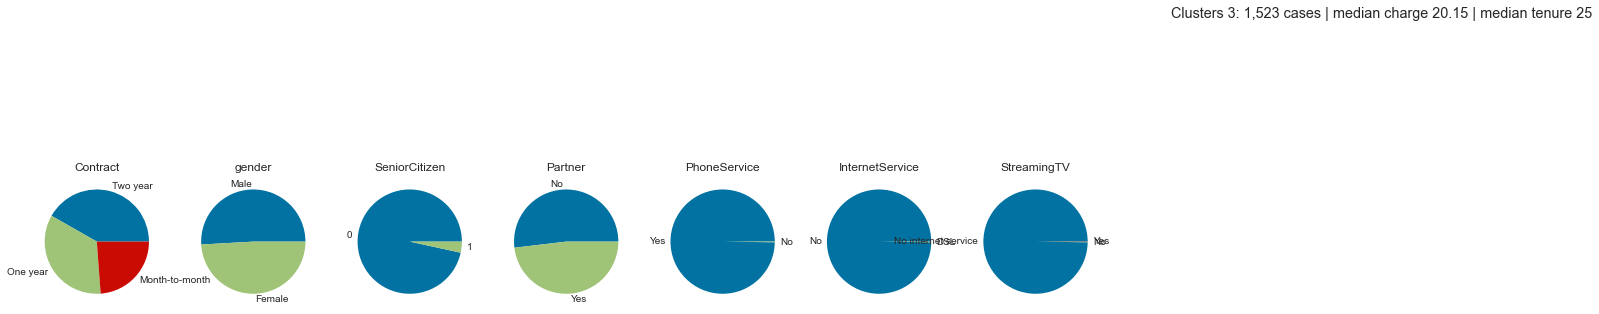

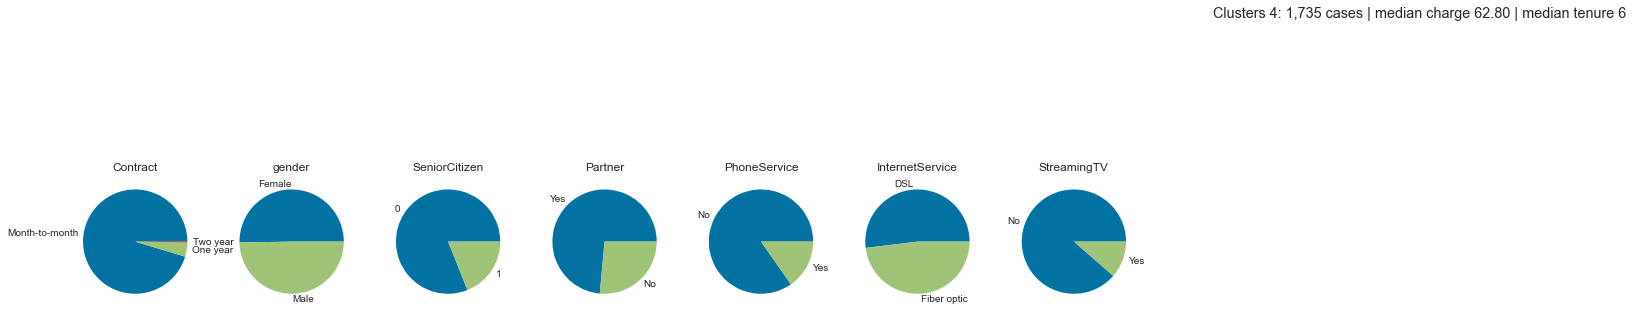

In [68]:
cluster_profile(df).T